# Calculs de shap values du modèle CatBoost sur 4 classes

### Imports

In [2]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

## Import des scripts python
import sys
import os
sys.path.append(os.path.abspath('../../python_scripts/'))

#import load_datas
import train_model as train
import save_model as saveModel
#import pickle_model

# Rechargement en cas de modification
import importlib
#importlib.reload(train)
##importlib.reload(saveModel)
#importlib.reload(pickle_model)

### Chargement des datasets

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

pd.set_option('display.max_columns', None)


X_train = pd.read_csv("../../../../Data/X_train.zip", compression=dict(method='zip', archive_name='X_train.csv'))
y_train = pd.read_csv("../../../../Data/y_train.zip", compression=dict(method='zip', archive_name='y_train.csv'))['grav']

X_test = pd.read_csv("../../../../Data/X_test.zip", compression=dict(method='zip', archive_name='X_test.csv'))
y_test = pd.read_csv("../../../../Data/y_test.zip", compression=dict(method='zip', archive_name='y_test.csv'))['grav']

print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)


X_train shape : (352893, 337)
X_test shape : (88224, 337)


### Chargement du meilleur modèle catboost

In [4]:
from sklearn.metrics import classification_report

file_name = "../2_grid_search_best_model/best_models/catboost_4_classes.gz"
model = saveModel.load(file_name)

# Prediction du model
y_pred = model.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     36264
           1       0.70      0.49      0.58     35517
           2       0.40      0.44      0.42     13992
           3       0.15      0.66      0.25      2451

    accuracy                           0.60     88224
   macro avg       0.50      0.59      0.50     88224
weighted avg       0.66      0.60      0.62     88224



## Interprétabilité avec shap

In [9]:
import shap

X_test_kmeans = shap.kmeans(X_test, k=10)

### Shap : Calcul des shap values

In [10]:

import shap


# explainer
explainer = shap.KernelExplainer(model.predict_proba,X_test_kmeans)

# InitJS
shap.initjs()

shap_values = explainer(X_test)

shap_values_save = shap_values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 88224/88224 [28:48:49<00:00,  1.18s/it]


### Summary plot de la classe 0 (Indemme)

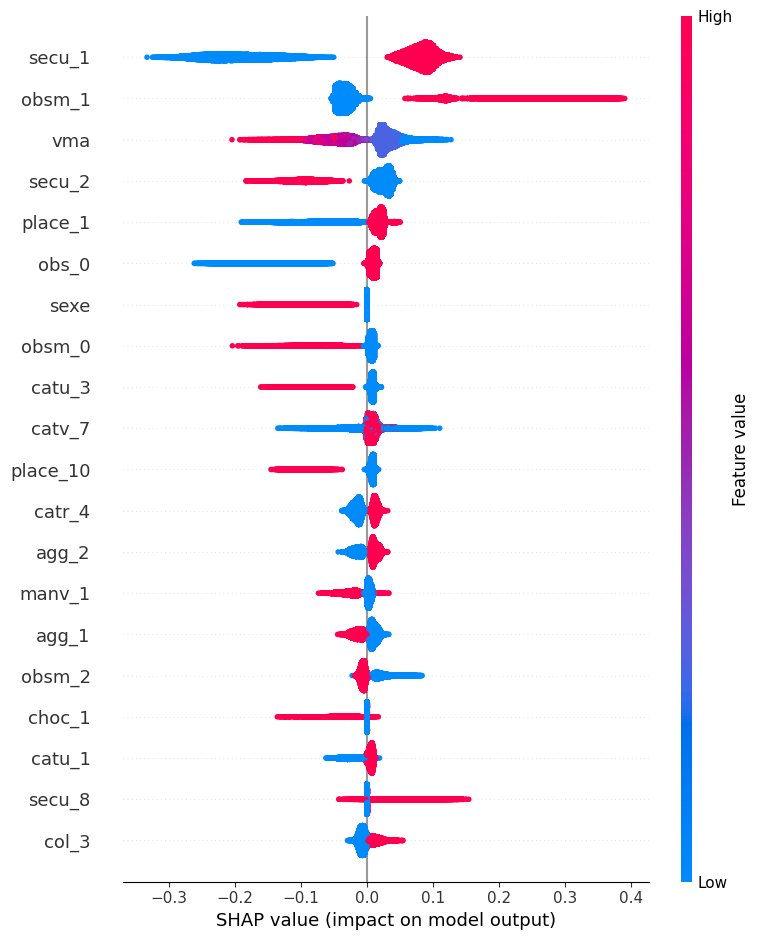

In [11]:
shap.summary_plot(shap_values[...,0])

### Summary plot de la classe 1 (Blésser léger)

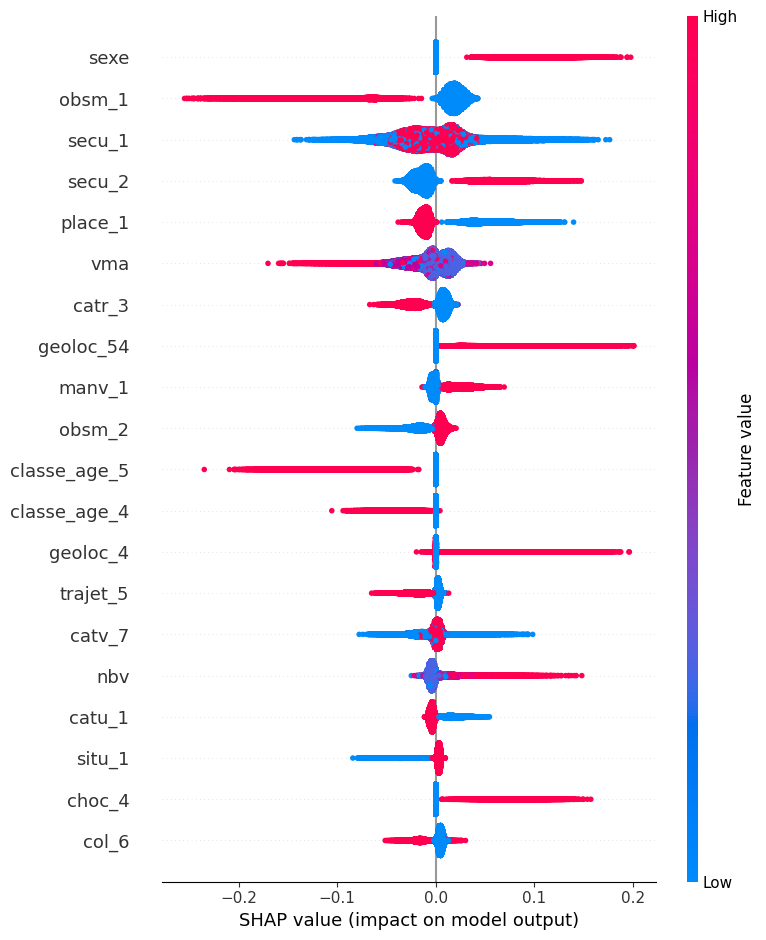

In [12]:
shap.summary_plot(shap_values[...,1])

### Summary plot de la classe 2 (Blésser hospitalisé)

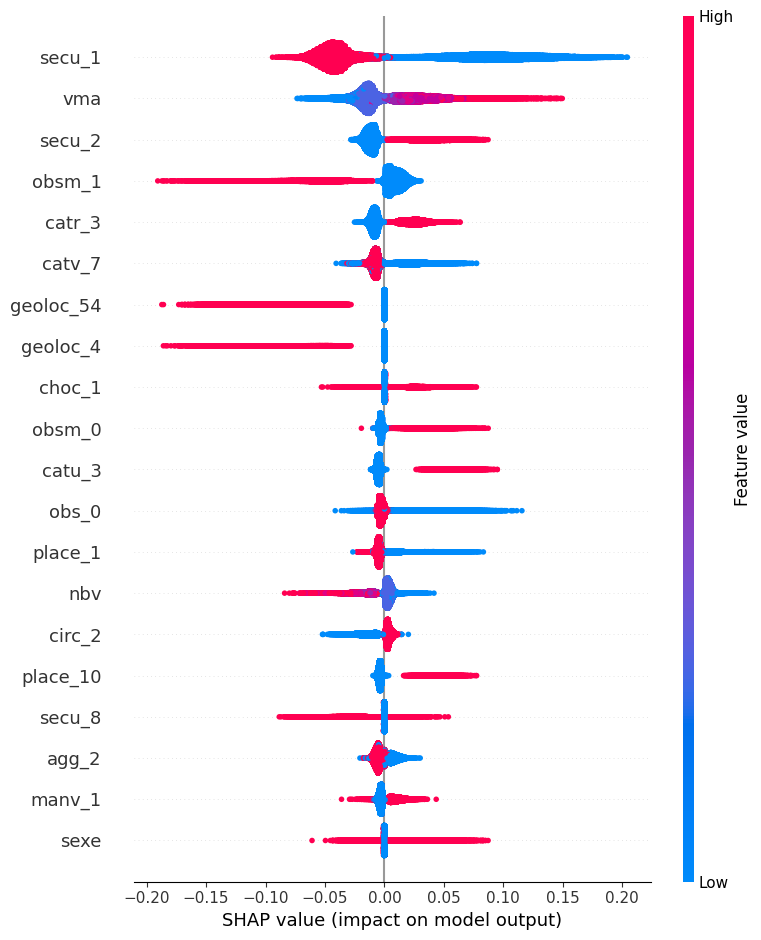

In [13]:
shap.summary_plot(shap_values[...,2])

#### Summary plot de la classe 3 (Tué)

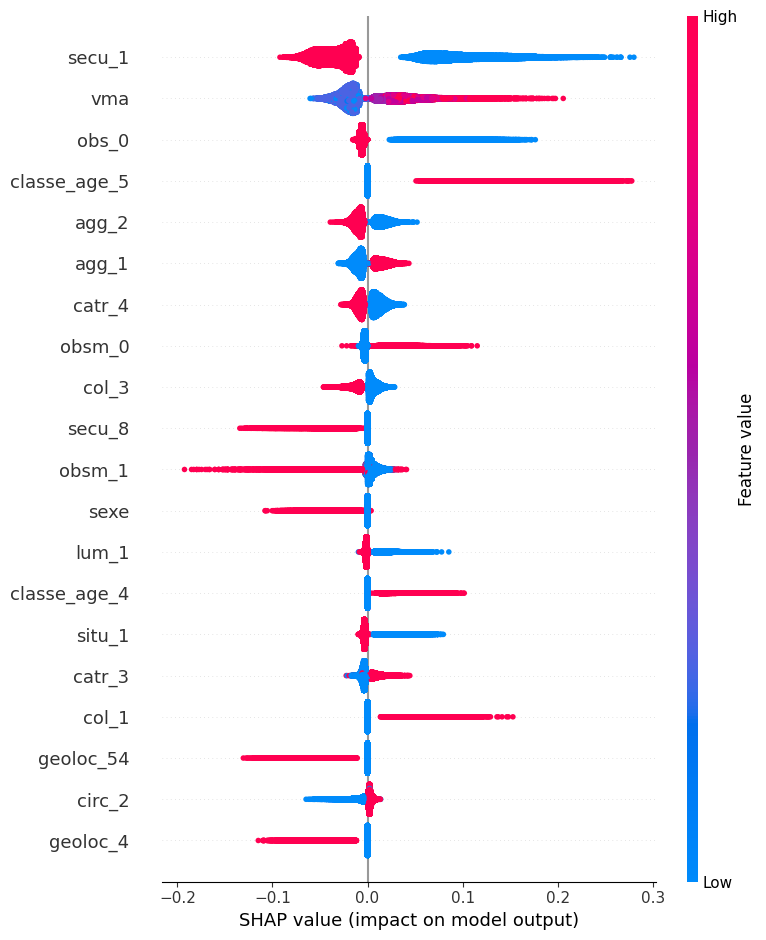

In [14]:
shap.summary_plot(shap_values[...,3])

### Sauvegarde de shap value en fichier csv

In [15]:

for i in range(0,4):
    shap_values_i=shap_values[...,i]
    shap_df = pd.DataFrame(shap_values_i.values,index=X_test.index ,columns=X_test.columns)
    shap_df['x_test_instance'] = shap_values_i.data.tolist()
    shap_df['base_values'] = shap_values_i.base_values

    file_name ='shape_value_files/1_final_catboost_values_data_classe_{}_geo'.format(i)
    shap_df.to_csv(file_name+'.zip'.format(i), index= False, compression=dict(method='zip', archive_name=file_name+'.csv'))



### Relecture du fichier de la classe 3 

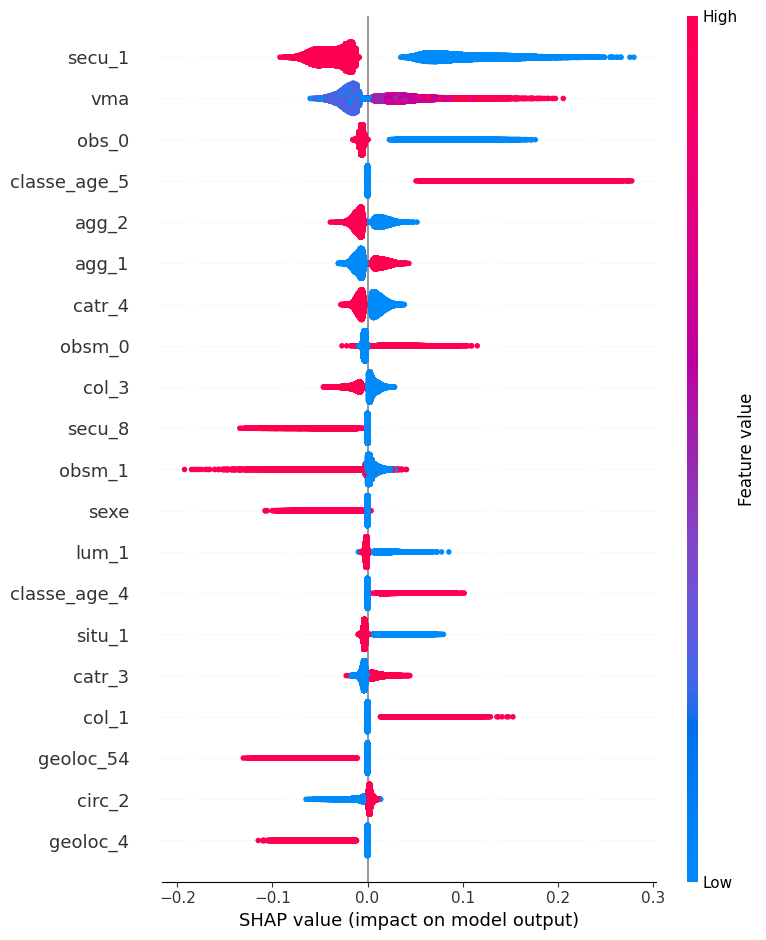

In [16]:
import shap
shap_df= pd.read_csv("shape_value_files/1_final_catboost_values_data_classe_3_geo.zip", \
                      compression=dict(method='zip', archive_name='1_final_values_data_classe_3_geo.csv'))

shap_values_csv = shap_df.drop(columns=['x_test_instance','base_values']).values
feature_names = shap_df.drop(columns=['x_test_instance','base_values']).columns

shap_exp = shap.Explanation(values=shap_values_csv, data=X_test, feature_names=feature_names)

shap.summary_plot(shap_exp)
